<a href="https://colab.research.google.com/github/umbertogagl97/Attacks-ART/blob/main/Attacco_Threshold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import iniziali**

Import ART

In [3]:
#importa ART
!pip install adversarial-robustness-toolbox

Librerie

In [4]:
#Librerie
import tensorflow as tf

tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import numpy as np

from art.estimators.classification import KerasClassifier
from art.utils import load_dataset

import cv2
from google.colab.patches import cv2_imshow

#import torch

#**Def variabili**

In [5]:
#salvataggio modello
model_save_name = 'model_DenseNet201'
path_model_save = F"/content/gdrive/My Drive/ModelliCNN/{model_save_name}" 

#immagini google
path_img_google="/content/gdrive/MyDrive/immagini_google/"

# **Collegamento google driv**e

In [6]:
#collegamento google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Dataset**

Load dataset stl10

In [7]:
#10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.
#96x96 pixels, colored.
(x_train, y_train), (x_test_tot, y_test_tot), min_, max_ = load_dataset(str("stl10")) #carica train e test set

In [8]:
print(x_train.shape,x_test_tot.shape)
#5000 immagini di train e 8000 di test: 500 train e 800 test per ogni classe

(5000, 96, 96, 3) (8000, 96, 96, 3)


Riduzione dataset set

In [9]:
#x_train, y_train = x_train[:500], y_train[:500] #prende solo le prime 500 immagini di training

#test set ridotto
x_test, y_test = x_test_tot[:10], y_test_tot[:10]

#test set totale
#x_test, y_test = x_test_tot, y_test_tot

Stampa dimensioni

In [10]:
im_shape = x_train[0].shape
print("dimensioni immagine: ",im_shape)
print("dimensioni train set: ",x_train.shape)
print("dimensioni vettore classi reali: ",y_train.shape)
print("dimensioni test set: ",x_test.shape)

dimensioni immagine:  (96, 96, 3)
dimensioni train set:  (5000, 96, 96, 3)
dimensioni vettore classi reali:  (5000, 10)
dimensioni test set:  (10, 96, 96, 3)


#Caricamento modello da drive

In [12]:
#load model
model= tf.keras.models.load_model(path_model_save)

# **Creazione classificatore ART**

In [13]:
#creazione classificatore di tipo Keras usando il modello addestrato, poiché ART supporta solo determinati classificatori
classifier = KerasClassifier(model=model, clip_values=(min_, max_)) #è un wrapper messo a disposizione da ART per creare un classificatore a partire da un modello addestrato

# **Testing su immagini originali**

In [11]:
# Evaluate the classifier on the test set 
value_preds=classifier.predict(x_test) #contiene i valori tra 0 e 1 predetti per ognuna delle 10 classi e per ogni immagine
preds = np.argmax(value_preds, axis=1) #(le predizioni vanno da 0 a 9 e indicano la classe predetta)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("Accuracy on test set:", (acc * 100))
#print("classi predette: ",preds)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Accuracy on test set: 70.0


# **Attacco Threshold**

Definizione attacco

In [16]:
from art.attacks.evasion import ThresholdAttack, PixelAttack
#Threshold attack
attack = ThresholdAttack(classifier,es=1,max_iter=10)
#attack = PixelAttack(classifier,es=1)

Generazione adversarial samples

In [ ]:
x_test_adv = attack.generate(x=x_test,y=y_test) #aggiunge una perturbazione alle immagini del test set
#N.B. si possono passare le classi reali del test set (con y=y_test) e in questo caso FGM calcolerà le perturbazioni in modo che il classificatore
#non predica queste classi. Mentre, se non passo y_test, le calcolerà in modo da non fargli predire la classe predetta normalmente (la quale può essere diversa da quella reale
#se il classificatore non è corretto)

#Calcolo perturbazioni

In [ ]:
perturb=x_test_adv-x_test #calcolo della perturbazione

#N.B. problema nel calcolo della perturbazione, con la sottrazione si ha un'immagine [-1,1], di seguito è normalizzata in [0,1]
min_p, max_p = np.amin(perturb), np.amax(perturb)
perturb = (perturb - min_p) / (max_p - min_p)
#se non normalizzo, la funzione che uso per stampare ritaglia automaticamente nell'intervallo [0,1] quindi perdo informazioni

#Calcolo perturbazione media

In [ ]:
perturbation_mean = np.mean(np.abs((x_test_adv - x_test)))
print('Average perturbation: {:4.2f}'.format(perturbation_mean))

Average perturbation: 0.00


#**Testing su immagini perturbate**

In [ ]:
# Evaluate the classifier on the adversarial samples FGM
value_preds_after=classifier.predict(x_test_adv)
preds_after = np.argmax(value_preds_after, axis=1)
acc_after = np.sum(preds_after == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("Accuracy on adversarial samples:", (acc_after * 100))
#print("classi predette su test set perturbato: ",preds_after)

Accuracy on adversarial samples: 86.0


# **Stampa subplot prime 10 immagini**

Immagine  0


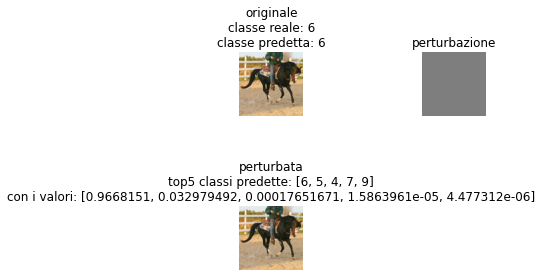

Immagine  1


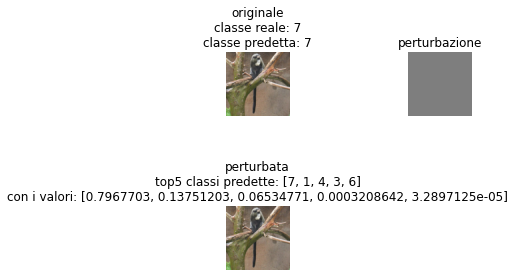

Immagine  2


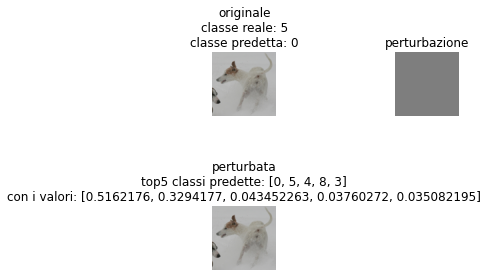

Immagine  3


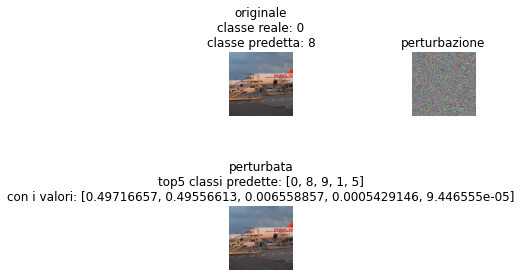

Immagine  4


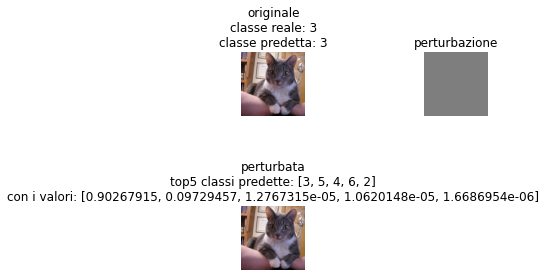

Immagine  5


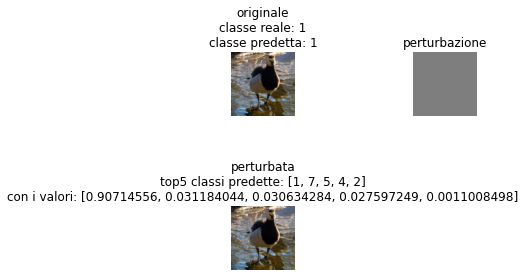

Immagine  6


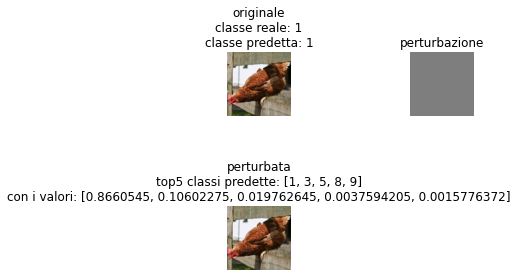

Immagine  7


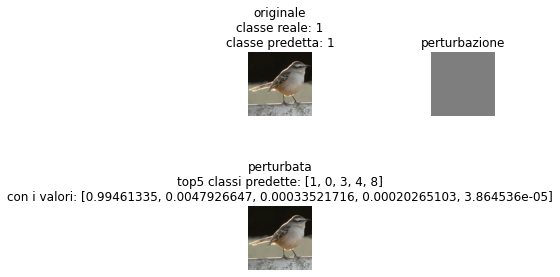

Immagine  8


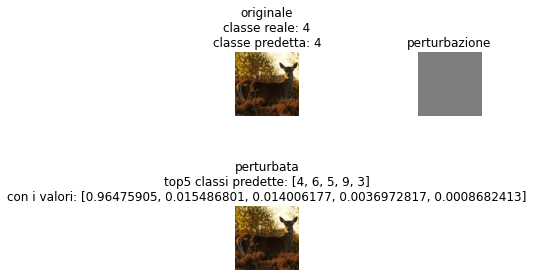

Immagine  9


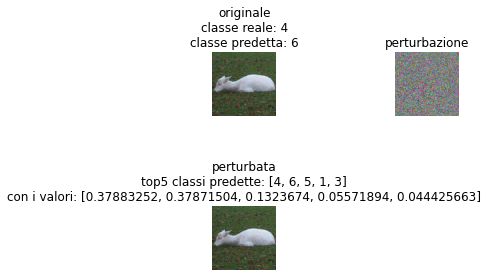

In [ ]:
#stampa subplot

#cv2_imshow(cv2.hconcat([x_test[0,:,:,:]*255,x_test[1,:,:,:]*255,x_test[2,:,:,:]*255]))
#N.B. plt.imshow usa range 0,1 per immagini rgb, mentre cv2 usa 0,255
import matplotlib.pyplot as plt    
#nel seguente ciclo for si crea un vettore delle classi predette ordinato per probabilità decrescente
for i in range(10):#(x_test.shape[0]):
  value=value_preds_after[i,:]
  value_sorted=sorted(value,reverse=True)
  classes=[]
  for j in range(value.size) :
    ind=np.where(value==value_sorted[j]) #restituisce l'indice in value del valore uguale a value_sorted[i], quindi è la classe
    classes.append(ind[0][0]) #classes è il vettore finale
  
  #in seguito per ogni immagine del test set si stampa un subplot
  fig = plt.figure()
  print("Immagine ",i)
  #originale
  ax1 = fig.add_subplot(321) #subplot con 3 righe e due colonne
  ax1.axis('off')
  ax1.imshow(cv2.rotate(x_test[i,:,:,:],cv2.cv2.ROTATE_90_CLOCKWISE))
  ax1.title.set_text("originale\nclasse reale: "+str(np.argmax(y_test[i,:]))+"\nclasse predetta: "+str(preds[i]))
  #perturbazione
  ax2 = fig.add_subplot(322)
  ax2.imshow(cv2.rotate(perturb[i,:,:,:],cv2.cv2.ROTATE_90_CLOCKWISE))
  ax2.axis('off')
  ax2.title.set_text("perturbazione")
  #perturbata
  ax3 = fig.add_subplot(325)
  ax3.imshow(cv2.rotate(x_test_adv[i,:,:,:],cv2.cv2.ROTATE_90_CLOCKWISE))
  ax3.axis('off')
  ax3.title.set_text("perturbata\ntop5 classi predette: "+str(classes[:5])+"\ncon i valori: "+str(value_sorted[:5]))

  plt.show()